# One Dimensional CNN for feature extraction

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512
latent_dim = 256
num_epochs = 50
learning_rate = 1e-3


In [12]:

def load_and_preprocess(data_path):
    data = np.load(data_path)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    tensor_data = torch.FloatTensor(scaled_data).unsqueeze(1)  # [N, 1, 38]
    return tensor_data, scaler

train_tensor, scaler = load_and_preprocess('/home/haoqian/anomaly/SMD/SMD_train.npy')
test_tensor, _ = load_and_preprocess('/home/haoqian/anomaly/SMD/SMD_test.npy')

train_dataset = TensorDataset(train_tensor, train_tensor) # Should be the same fro reconstuction task
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [17]:
import torch.nn as nn

class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
            
        out += residual
        out = self.relu(out)
        return out

class TimeSeriesAE(nn.Module):
    def __init__(self, input_dim=38, latent_dim=64):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=7, padding=3, stride=2),  # [64, 19]
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),  # [64, 10]
            
            self._make_layer(64, 64, 2),
            self._make_layer(64, 128, 2, stride=2),  # [128, 5]
            self._make_layer(128, 256, 2, stride=2),  # [256, 3]
            
            nn.AdaptiveAvgPool1d(1),  # [256, 1]
            nn.Flatten(),
            nn.Linear(256, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.Unflatten(1, (256, 1)),
            
            nn.Upsample(scale_factor=3),  # [256, 3]
            self._make_layer(256, 256, 2, decoder=True),
            
            nn.Upsample(scale_factor=2),  # [256, 6]
            self._make_layer(256, 128, 2, decoder=True),
            
            nn.Upsample(scale_factor=2),  # [128, 12]
            self._make_layer(128, 64, 2, decoder=True),
            
            nn.Upsample(size=19),  # [64, 19]
            self._make_layer(64, 64, 2, decoder=True),
            
            nn.Upsample(size=38),  # [64, 38]
            nn.Conv1d(64, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )
    
    def _make_layer(self, in_channels, out_channels, blocks, stride=1, decoder=False):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            if not decoder:
                downsample = nn.Sequential(
                    nn.Conv1d(in_channels, out_channels, kernel_size=1,
                             stride=stride, bias=False),
                    nn.BatchNorm1d(out_channels))
            else:
                downsample = nn.Sequential(
                    nn.Upsample(scale_factor=stride),
                    nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False),
                    nn.BatchNorm1d(out_channels))
                
        layers = []
        layers.append(ResidualBlock1D(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels))
            
        return nn.Sequential(*layers) #nn.Sequential(layer1, layer2,...)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    



In [21]:
def validate_dimensions(model, input_dim=38):
    test_input = torch.randn(1, 1, input_dim).to(device)
    model.eval()
    with torch.no_grad():
        output = model(test_input)
    print(f"Input shape: {test_input.shape}, Output shape: {output.shape}")
    if test_input.shape != output.shape:
        output = output[:, :, :input_dim]  
        print(f"Adjusted output shape: {output.shape}")
    assert test_input.shape == output.shape, "Dimension mismatch!"
    print("Dimension check passed!")
    return output.shape == test_input.shape



model = TimeSeriesAE(latent_dim=latent_dim).to(device)
if not validate_dimensions(model):
    print("Applying safe dimension adjustment...")
    original_forward = model.forward
    def adjusted_forward(self, x):
        output = original_forward(x)
        return output[:, :, :x.size(2)] 
    model.forward = adjusted_forward.__get__(model, TimeSeriesAE)
    validate_dimensions(model)

criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99)

loss_data=[]
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    avg_loss=total_loss/len(train_loader)
    loss_data.append(avg_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.6f}')



Input shape: torch.Size([1, 1, 38]), Output shape: torch.Size([1, 1, 38])
Dimension check passed!
Epoch [1/50], Loss: 0.436148
Epoch [2/50], Loss: 0.389137
Epoch [3/50], Loss: 0.384099
Epoch [4/50], Loss: 0.382069
Epoch [5/50], Loss: 0.380794
Epoch [6/50], Loss: 0.380506
Epoch [7/50], Loss: 0.380013
Epoch [8/50], Loss: 0.379614
Epoch [9/50], Loss: 0.379396
Epoch [10/50], Loss: 0.379168
Epoch [11/50], Loss: 0.378515
Epoch [12/50], Loss: 0.378380
Epoch [13/50], Loss: 0.378335
Epoch [14/50], Loss: 0.378112
Epoch [15/50], Loss: 0.378014
Epoch [16/50], Loss: 0.377978
Epoch [17/50], Loss: 0.377850
Epoch [18/50], Loss: 0.377685
Epoch [19/50], Loss: 0.377503
Epoch [20/50], Loss: 0.378536
Epoch [21/50], Loss: 0.377357
Epoch [22/50], Loss: 0.377476
Epoch [23/50], Loss: 0.377349
Epoch [24/50], Loss: 0.377196
Epoch [25/50], Loss: 0.377093
Epoch [26/50], Loss: 0.377059
Epoch [27/50], Loss: 0.377146
Epoch [28/50], Loss: 0.377206
Epoch [29/50], Loss: 0.377069
Epoch [30/50], Loss: 0.377062
Epoch [31/5

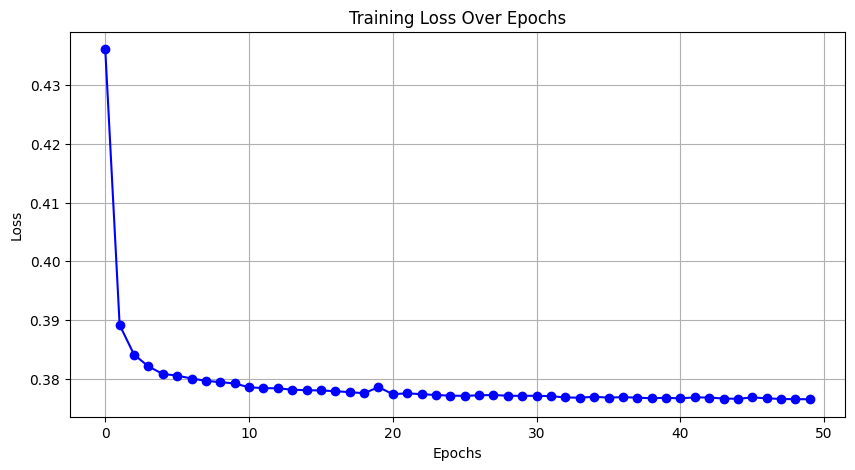

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_data, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.xticks(range(len(loss_data))) 
plt.grid()
plt.show()

In [24]:

def extract_features(model, data_tensor, batch_size=1024, save_path=None):
    model.eval()
    dataloader = DataLoader(data_tensor, batch_size=batch_size)
    
    all_features = []
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch.to(device)
            features = model.encoder(inputs)
            all_features.append(features.cpu().numpy())
    
    features_array = np.concatenate(all_features, axis=0)
    if save_path:
        np.save(save_path, features_array)
    return features_array


train_features = extract_features(model, train_tensor, save_path='/home/haoqian/anomaly/features/cnn/CNN_train_features.npy')
test_features = extract_features(model, test_tensor,save_path='/home/haoqian/anomaly/features/cnn/CNN_test_features.npy')

print(f"Feature extraction completed. Train features shape: {train_features.shape}, Test features shape: {test_features.shape}")

Feature extraction completed. Train features shape: (708405, 256), Test features shape: (708420, 256)


In [30]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

train_features = np.load('/home/haoqian/anomaly/features/cnn/CNN_train_features.npy')
test_features = np.load('/home/haoqian/anomaly/features/cnn/CNN_test_features.npy')
train_data = np.load('/home/haoqian/anomaly/SMD/SMD_train.npy')  # (708405, 38)
test_data = np.load('/home/haoqian/anomaly/SMD/SMD_test.npy')  # (708420, 38)
input_data_train=np.hstack([train_features,train_data])
input_data_test=np.hstack([test_features,test_data])
print(input_data_train.shape)
print(input_data_test.shape)

(708405, 294)
(708420, 294)


In [4]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

def performance_measurement(test_label, pred_label):
    precision = precision_score(test_label, pred_label, zero_division=0)
    recall = recall_score(test_label, pred_label, zero_division=0)
    f1 = f1_score(test_label, pred_label, zero_division=0)
    try:
        auc_roc = roc_auc_score(test_label, pred_label)
    except ValueError:
        auc_roc = 0.0 
    return [
        round(precision, 4),
        round(recall, 4),
        round(f1, 4),
        round(auc_roc, 4)
    ]

train_data = np.load('/home/haoqian/anomaly/SMD/SMD_train.npy')  # (708405, 38)
test_data = np.load('/home/haoqian/anomaly/SMD/SMD_test.npy')  # (708420, 38)
test_label = np.load('/home/haoqian/anomaly/SMD/SMD_test_label.npy')  # (708420,)

train_features = np.load('/home/haoqian/anomaly/features/cnn/CNN_train_features.npy')
test_features = np.load('/home/haoqian/anomaly/features/cnn/CNN_test_features.npy')

input_data_train=np.hstack([train_features,train_data])
input_data_test=np.hstack([test_features,test_data])

print("="*80)

print("Feature Fusion dimention:")

print(input_data_train.shape)
print(input_data_test.shape)


print("="*80)
print("Isolation Forest on Original Data")
print("="*80)


if_original = IsolationForest(n_estimators=200, 
                             max_samples=256, 
                             contamination='auto', 
                             random_state=42)
if_original.fit(train_data)

original_scores = -if_original.score_samples(test_data) 
original_pred = (original_scores > np.quantile(original_scores, 0.95)).astype(int) 

metrics_original = performance_measurement(test_label, original_pred)
print(f"Precision: {metrics_original[0]}")
print(f"Recall: {metrics_original[1]}")
print(f"F1-score: {metrics_original[2]}")
print(f"AUC-ROC: {metrics_original[3]}")

print("\n" + "="*80)
print("Isolation Forest on Extracted Features")
print("="*80)


if_features = IsolationForest(n_estimators=200, 
                            max_samples=256, 
                            contamination='auto', 
                            random_state=42)
if_features.fit(train_features)

features_scores = -if_features.score_samples(test_features)
feature_pred = (features_scores > np.quantile(features_scores, 0.95)).astype(int)

metrics_features = performance_measurement(test_label, feature_pred)
print(f"Precision: {metrics_features[0]}")
print(f"Recall: {metrics_features[1]}")
print(f"F1-score: {metrics_features[2]}")
print(f"AUC-ROC: {metrics_features[3]}")

print("\n" + "="*80)
print("Isolation Forest on Extracted Features and Original Data")
print("="*80)


if_comb = IsolationForest(n_estimators=200, 
                            max_samples=256, 
                            contamination='auto', 
                            random_state=42)
if_comb.fit(input_data_train)

comb_scores = -if_comb.score_samples(input_data_test)
comb_pred = (comb_scores > np.quantile(comb_scores, 0.95)).astype(int)

# 评估指标
metrics_comb = performance_measurement(test_label, comb_pred)
print(f"Precision: {metrics_comb[0]}")
print(f"Recall: {metrics_comb[1]}")
print(f"F1-score: {metrics_comb[2]}")
print(f"AUC-ROC: {metrics_comb[3]}")


Feature Fusion dimention:
(708405, 294)
(708420, 294)
Isolation Forest on Original Data
Precision: 0.1546
Recall: 0.1859
F1-score: 0.1688
AUC-ROC: 0.5709

Isolation Forest on Extracted Features
Precision: 0.2098
Recall: 0.2524
F1-score: 0.2292
AUC-ROC: 0.6056

Isolation Forest on Extracted Features and Original Data
Precision: 0.2115
Recall: 0.2545
F1-score: 0.231
AUC-ROC: 0.6067


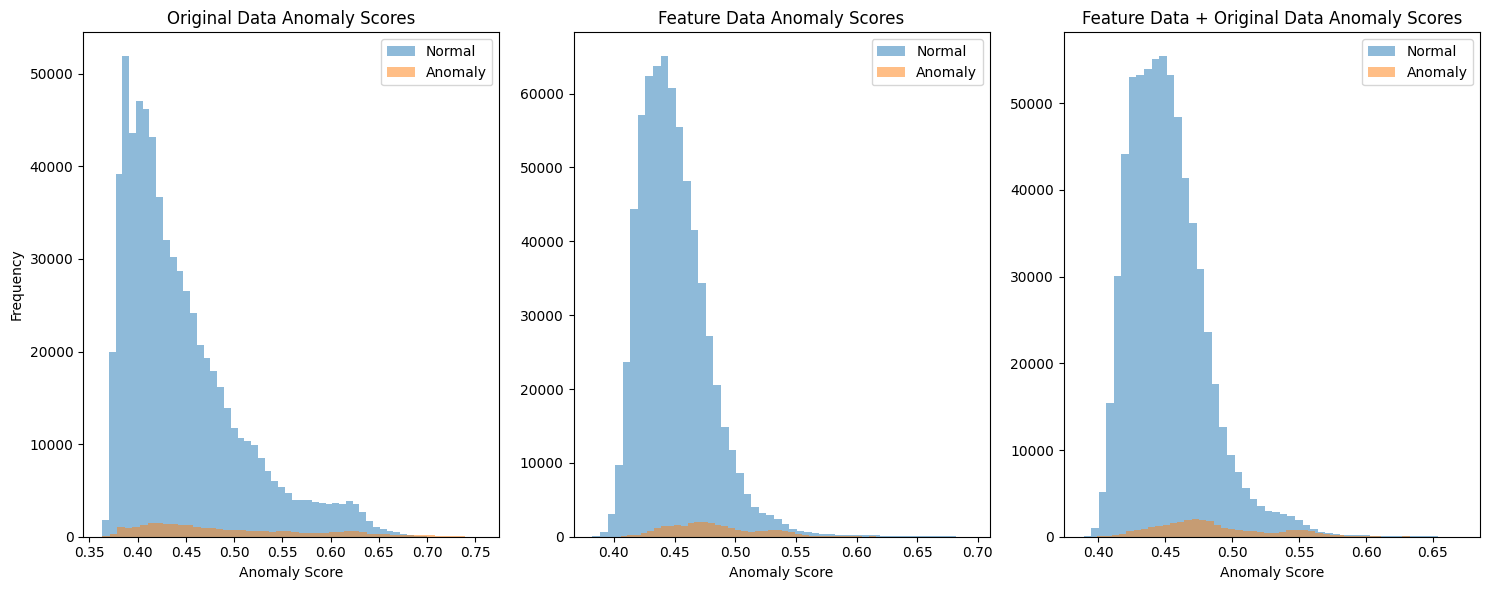

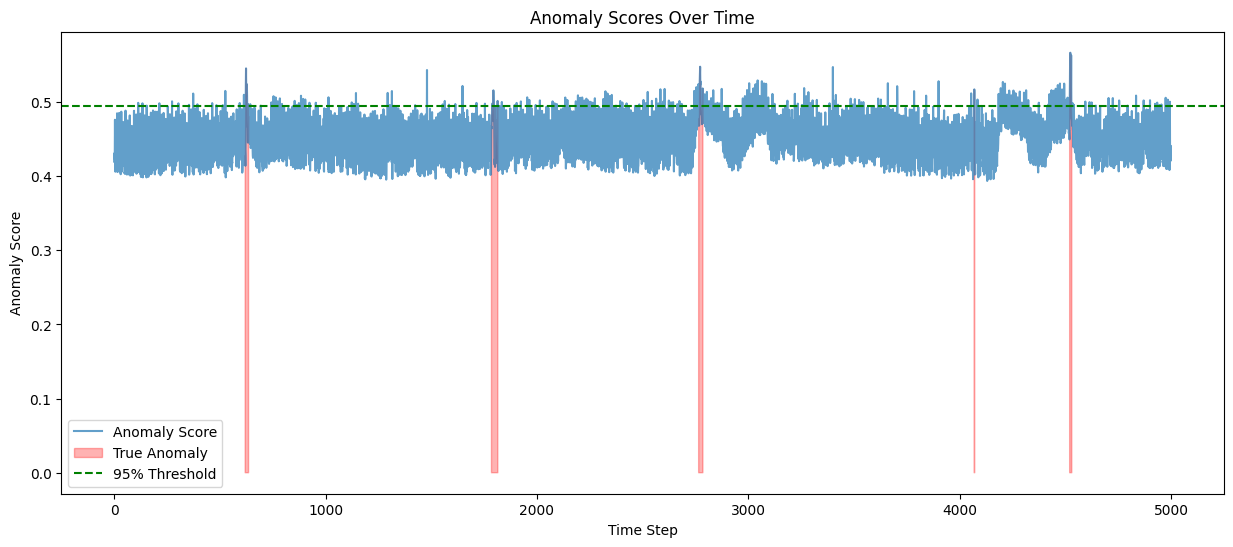

In [6]:
# 3. 结果可视化
plt.figure(figsize=(15, 6))

# 原始数据异常分数分布
plt.subplot(1, 3, 1)
plt.hist(original_scores[test_label==0], bins=50, alpha=0.5, label='Normal')
plt.hist(original_scores[test_label==1], bins=50, alpha=0.5, label='Anomaly')
plt.title("Original Data Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()

# 特征数据异常分数分布
plt.subplot(1, 3, 2)
plt.hist(features_scores[test_label==0], bins=50, alpha=0.5, label='Normal')
plt.hist(features_scores[test_label==1], bins=50, alpha=0.5, label='Anomaly')
plt.title("Feature Data Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.legend()

# 特征数据+原始数据异常分数分布
plt.subplot(1, 3, 3)
plt.hist(comb_scores[test_label==0], bins=50, alpha=0.5, label='Normal')
plt.hist(comb_scores[test_label==1], bins=50, alpha=0.5, label='Anomaly')
plt.title("Feature Data + Original Data Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.legend()

plt.tight_layout()
#plt.savefig('/home/haoqian/anomaly/SMD/iforest_results.png')
plt.show()

# 4. 保存预测结果
#np.save('/home/haoqian/anomaly/SMD/original_iforest_scores.npy', original_scores)
#np.save('/home/haoqian/anomaly/SMD/feature_iforest_scores.npy', feature_scores)

# 5. 时间维度分析（可选）
def plot_time_series_anomalies(data, scores, labels, window=1000):
    plt.figure(figsize=(15, 6))
    plt.plot(scores, label='Anomaly Score', alpha=0.7)
    plt.fill_between(range(len(scores)), 
                    scores, 
                    where=labels==1,
                    color='r', alpha=0.3, label='True Anomaly')
    plt.axhline(y=np.quantile(scores, 0.95), color='g', linestyle='--', label='95% Threshold')
    plt.title("Anomaly Scores Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Anomaly Score")
    plt.legend()
 #   plt.savefig('/home/haoqian/anomaly/SMD/time_series_anomalies.png')
    plt.show()

# 选择前10000个点展示
plot_time_series_anomalies(test_data[10000:15000], 
                          comb_scores[10000:15000], 
                          test_label[10000:15000])